# Requirimentos

In [2]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def predict_reg(df_model):
    ano_max = max(df_model['ano'])  
    mes_max = max(df_model[df_model['ano']==ano_max]['mes'])
    periodo_to_predict_month = 24
    colunas = ['ano', 'mes','genero_', 'contrato_Prod',
                'contrato_Refin', 
            'valor_principal_Prod', 'valor_principal_Port + Refin', 'contrato_Port + Refin',
            'valor_principal_Refin','valor_principal_Refin_lag1', 'valor_principal_Prod_lag2',
            'contrato_Prod_lag2', 'contrato_Refin_lag1','valor_principal_Port + Refin_lag1', 'contrato_Port + Refin_lag1']

    df_final = df_model.copy()
    df_final[f'contrato_Refin_lag1'] = df_final.groupby(['genero_'])['contrato_Refin'].shift(1)
    df_final[f'contrato_Prod_lag2'] = df_final.groupby(['genero_'])['contrato_Prod'].shift(2)
    df_final[f'valor_principal_Refin_lag1'] = df_final.groupby(['genero_'])['valor_principal_Refin'].shift(1)
    df_final[f'valor_principal_Prod_lag2'] = df_final.groupby(['genero_'])['contrato_Prod'].shift(2)
    df_final[f'valor_principal_Port + Refin_lag1'] = df_final.groupby(['genero_'])['valor_principal_Port + Refin'].shift(1)
    df_final[f'contrato_Port + Refin_lag1'] = df_final.groupby(['genero_'])['contrato_Port + Refin'].shift(1)
    df_final = df_final[colunas]

    for i in range(24):
        if mes_max%12==0:
            ano_max += 1
            mes_max = 1
        else:
            mes_max += 1

        df_aux = pd.DataFrame([(ano_max,mes_max, 'F'), (ano_max,mes_max, 'M'), (ano_max,mes_max, 'Null')], columns=['ano', 'mes','genero_'])
        df_aux = pd.merge(df_aux, pd.get_dummies(df_aux['genero_'], drop_first=True, dtype=int), how='left', left_index=True, right_index=True)

        for target, model, lag in [('contrato_Prod', 'model_vol_prod',2),	('contrato_Refin','model_vol_refin',1),
                                ('valor_principal_Prod', 'model_valor_prod',2),	('valor_principal_Refin', 'model_valor_refin',1),
                                ('valor_principal_Port + Refin','model_valor_port_refin',1), ('contrato_Port + Refin','model_vol_port_refin',1)]:
            lista = []
            #for i in range(periodo_to_predict_month):
            lag_f = df_final[df_final['genero_']=='F'][target].iloc[-lag]
            lag_m = df_final[df_final['genero_']=='M'][target].iloc[-lag]
            lag_null = df_final[df_final['genero_']=='Null'][target].iloc[-lag]
            df_aux.loc[df_aux['M']==1, f'{target}_lag{lag}'] = lag_m
            df_aux.loc[df_aux['Null']==1, f'{target}_lag{lag}'] = lag_null
            df_aux[f'{target}_lag{lag}'] = df_aux[f'{target}_lag{lag}'].fillna(lag_f)
            valor_predito = globals()[model].predict(sm.add_constant(df_aux[['ano', 'M', 'Null', f'{target}_lag{lag}']].values , has_constant='add'))
            df_aux.loc[df_aux['M']==1, target] = valor_predito[1]
            df_aux.loc[df_aux['Null']==1, target] = valor_predito[2]
            df_aux[target] = df_aux[target].fillna(valor_predito[0])
        
        
        df_final = pd.concat([df_final[colunas], df_aux[colunas]]).reset_index(drop=True)
        df_final = pd.merge(df_final, pd.get_dummies(df_final['genero_'], drop_first=True, dtype=int), how='left', left_index=True, right_index=True)
        if 'Port + Refin' in target:
            df_final_alter = df_final.dropna()
            x_sm = sm.add_constant(df_final_alter[['ano', 'M', 'Null', f'{target}_lag{lag}']].values, has_constant='add')
            y = df_final_alter[[target]].values.reshape(-1, 1)
        else:
            x_sm = sm.add_constant(df_final[['ano', 'M', 'Null', f'{target}_lag{lag}']].values, has_constant='add')
            y = df_final[[target]].values.reshape(-1, 1)
        globals()[model] = sm.OLS(y, x_sm).fit()
    return df_final
    
def PlotPredito(df_final):
    fig, axs = plt.subplots(2, 2,figsize=(17, 9))

    plt.subplots_adjust(hspace=0.4)
    plt.subplots_adjust(wspace=0.4)
    formatter = mdates.DateFormatter("%Y") ### formatter of the date
    locator = mdates.YearLocator(1) ### where to put the label

    df_aux = df_final.groupby('ano_mes').agg({'valor_principal_Refin':'sum', 'valor_principal_Prod':'sum', 'valor_principal_Port + Refin':'sum'}).reset_index()
    axs[0][0].plot('ano_mes', 'valor_principal_Refin', 'lightblue', data = df_aux[:-24], label='Refin')
    axs[0][0].plot('ano_mes', 'valor_principal_Refin', 'black', data = df_aux[-25:], label = 'Predito')

    axs[0][0].plot('ano_mes', 'valor_principal_Prod', 'steelblue', data = df_aux[:-24], label='Prod')
    axs[0][0].plot('ano_mes', 'valor_principal_Prod', 'black', data = df_aux[-25:],label='')

    axs[0][0].plot('ano_mes', 'valor_principal_Port + Refin', 'lightgray', data = df_aux[:-24], label='Port + Refin')
    axs[0][0].plot('ano_mes', 'valor_principal_Port + Refin', 'black', data = df_aux[-25:],label='')
    axs[0][0].legend(loc='upper left')
    axs[0][0].set_title('Gráfico de projeção de crescimento \n Valor da carteira')

    axs[0][1].stackplot('ano_mes',
                        'valor_principal_Refin',
                        'valor_principal_Port + Refin',
                        'valor_principal_Prod',
                            data = df_aux[:-24],
                            labels=['Refin', 'Port + Refin','Prod'],
                            colors=['lightblue', 'lightgray', 'steelblue'])

    axs[0][1].stackplot('ano_mes',
                        'valor_principal_Refin',
                        'valor_principal_Port + Refin',
                        'valor_principal_Prod',
                            data = df_aux[-25:],
                            labels=['Predito'],
                            colors=['black']
    )

    axs[0][1].legend(loc='upper left')
    axs[0][1].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axs[0][1].xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    axs[0][1].set_title('Gráfico de projeção consolidado \n Valor da carteira')

    df_aux = df_final.groupby('ano_mes').agg({'contrato_Refin':'sum', 'contrato_Port + Refin':'sum', 'contrato_Prod':'sum'}).reset_index()
    axs[1][0].plot('ano_mes', 'contrato_Refin', 'navajowhite', data = df_aux[:-24],label='Refin')
    axs[1][0].plot('ano_mes', 'contrato_Refin', 'black', data = df_aux[-25:],label='Predito')

    axs[1][0].plot('ano_mes', 'contrato_Prod', 'goldenrod', data = df_aux[:-24],label='Prod')
    axs[1][0].plot('ano_mes', 'contrato_Prod', 'black', data = df_aux[-25:],label='')

    axs[1][0].plot('ano_mes', 'contrato_Port + Refin', 'darkkhaki', data = df_aux[:-24],label='Port + Refin')
    axs[1][0].plot('ano_mes', 'contrato_Port + Refin', 'black', data = df_aux[-25:],label='')
    axs[1][0].legend(loc='upper left')
    axs[1][0].set_title('Gráfico de projeção de crescimento \n Volume de operações')


    axs[1][1].stackplot('ano_mes',
                        'contrato_Refin',
                        'contrato_Port + Refin',
                        'contrato_Prod',
                            data = df_aux[:-24],
                            labels=[ 'Refin','Port + Refin', 'Prod'],
                            colors=['darkkhaki', 'navajowhite', 'goldenrod'])

    axs[1][1].stackplot('ano_mes',
                        'contrato_Refin',
                        'contrato_Port + Refin',
                        'contrato_Prod',
                            data = df_aux[-25:],
                            labels=['Predito'],
                            colors=['black']
    )
    axs[1][1].legend(loc='upper left')
    axs[1][1].xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    axs[1][1].xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    axs[1][1].set_title('Gráfico de projeção consolidado \n Volume da carteira')
    plt.show()
    
def preprocess(df, target):
    df_model = df.copy()
    df_model = ConstructDfPivotLags(df_model, target)
    df_model = pd.merge(df_model, pd.get_dummies(df_model['genero_'], drop_first=True, dtype=int), how='left', left_index=True, right_index=True)
    df_model = df_model.dropna()
    return df_model

def run_models_reg(df, lag, target):
    df_model = preprocess(df, target)
    x = df_model[['ano', #'mes',#'F',
                'M','Null'
                ,f'{target}_lag{lag}'
                ]].values
    y = df_model[[target]].values.reshape(-1, 1)

    x_sm = sm.add_constant(x)
        
    # Ajustando o modelo de regressão
    model = sm.OLS(y, x_sm).fit()
    print(model.summary())
    return model

def ConstructDfPivotLags(df, target):
    df_aux = df.copy()
    df_aux[f'{target}_lag1'] = df_aux.groupby(['genero_'])[target].shift(1)
    df_aux[f'{target}_lag2'] = df_aux.groupby(['genero_'])[target].shift(2)
    df_aux[f'{target}_lag3'] = df_aux.groupby(['genero_'])[target].shift(3)
    df_aux[f'{target}_lag4'] = df_aux.groupby(['genero_'])[target].shift(4)
    df_aux[f'{target}_lag5'] = df_aux.groupby(['genero_'])[target].shift(5)
    return df_aux

In [3]:
df_operacao = pd.read_csv('dados/dados_operacoes.csv')
df_operacao['ano_mes'] = pd.to_datetime(pd.to_datetime(df_operacao['data_operacao']).dt.strftime('%Y-%m') + '-01')

# Modelagem

##### Feature engineering

Seguindo o que foi desenvolvido nas outras seções, será feita projeção de crescimento utilizando a regressão linear e como variáveis dependetes: 'Ano', 'Gênero' e variável com lag. Primeiro passo é construir o cubo inicial, que está abaixo:

In [4]:
df_model = df_operacao.groupby(['ano_mes', 'genero', 'operacao'])\
                      .agg({'contrato':'count', 'valor_principal':'sum'})\
                      .unstack(2)\
                      .reset_index()

df_model.columns = [i+'_'+j for i,j in df_model.columns]
df_model['ano'] = df_model['ano_mes_'].dt.year
df_model['mes'] = df_model['ano_mes_'].dt.month
df_model

,ano_mes_,genero_,contrato_Port + Refin,contrato_Prod,contrato_Refin,valor_principal_Port + Refin,valor_principal_Prod,valor_principal_Refin,ano,mes
0,2019-01-01,F,18.0,78.0,38.0,356767.67,2251275.59,442156.26,2019,1
1,2019-01-01,M,10.0,61.0,26.0,180070.04,1873616.77,272502.13,2019,1
2,2019-01-01,Null,6.0,12.0,5.0,156163.71,248584.10,55002.65,2019,1
3,2019-02-01,F,12.0,79.0,40.0,304585.99,2267916.77,378103.02,2019,2
4,2019-02-01,M,9.0,32.0,19.0,189066.54,913248.21,162924.42,2019,2
...,...,...,...,...,...,...,...,...,...,...
139,2022-11-01,M,15.0,78.0,32.0,333562.82,2335026.97,349784.98,2022,11
140,2022-11-01,Null,7.0,21.0,10.0,137089.20,560965.85,67383.75,2022,11
141,2022-12-01,F,27.0,151.0,64.0,567836.61,4664036.40,648777.17,2022,12
142,2022-12-01,M,8.0,63.0,34.0,198030.25,1917708.22,274259.85,2022,12


Note que o cubo construído possuí uma série temporal para cada tipo de operação, a saber:
* Port + Refin
* Refin
* Prod

Note também que variáveis com prefixo "contrato" denotam volume de operações da carteira e com prefixo "valor_principal" denotam valor da carteira. São em cima dessas variáveis que serão rodadas regressões lineares, para projetar crescimento.

Agora é visto como os modelos performam com lags que variam de 1 até 5. Resultado é disponibilizado na tela abaixo. Essa tela será deixada comentada e será apresentado apenas os resultados para os modelos.

In [5]:
#targets = ['contrato_Port + Refin',	'contrato_Prod',	'contrato_Refin',	'valor_principal_Port + Refin',	'valor_principal_Prod',	'valor_principal_Refin']
#for i in targets:
#    for j in range(1,6):
#        print(f'Coluna: {i}, lag: {j}')
#        run_models_reg(df_model, j, i)

Devido aos resultados dos modelos foram escolhidos os lags 2, 1 e 1 para series temporais da operacao Prod, Refin e Port + Refin repectivamente. Apesar de a série Port + Refin não mostrar autocorrelação temporal e ser estacionária, não exibindo tendência clara também será utilizada a regressão linear. 

##### Modelos para previsão

Nessa seção serão apresentados os modelos e os lags utilizados e as respectivas métricas da regressão linear.

##### Volume Operações e Valor Principal Prod

Valores de R2 ajustado e R2 acima de 0.9. Todas as variáveis dependentes com p-value menor que 0.05, o que significa que são estatisticamente significantes.

In [6]:
model_vol_prod = run_models_reg(df_model, 2, 'contrato_Prod')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     575.1
Date:                Wed, 08 May 2024   Prob (F-statistic):           1.09e-77
Time:                        06:57:35   Log-Likelihood:                -462.17
No. Observations:                 126   AIC:                             934.3
Df Residuals:                     121   BIC:                             948.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.164e+04   2229.006     -5.223      0.0

In [7]:
model_valor_prod = run_models_reg(df_model, 2, 'valor_principal_Prod')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     503.3
Date:                Wed, 08 May 2024   Prob (F-statistic):           2.27e-74
Time:                        06:57:35   Log-Likelihood:                -1769.8
No. Observations:                 126   AIC:                             3550.
Df Residuals:                     121   BIC:                             3564.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.619e+08   7.04e+07     -5.140      0.0

##### Volume Operações e Valor Principal Refin

Valores de R2 ajustado e R2 acima de 0.88. Todas as variáveis dependentes com p-value menor que 0.05, o que significa que são estatisticamente significantes.

In [8]:
model_vol_refin = run_models_reg(df_model, 1, 'contrato_Refin')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     278.0
Date:                Wed, 08 May 2024   Prob (F-statistic):           5.58e-60
Time:                        06:57:36   Log-Likelihood:                -416.79
No. Observations:                 126   AIC:                             843.6
Df Residuals:                     121   BIC:                             857.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6364.9852   1467.803     -4.336      0.0

In [9]:
model_valor_refin = run_models_reg(df_model, 1, 'valor_principal_Refin')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     246.9
Date:                Wed, 08 May 2024   Prob (F-statistic):           3.49e-57
Time:                        06:57:36   Log-Likelihood:                -1587.5
No. Observations:                 126   AIC:                             3185.
Df Residuals:                     121   BIC:                             3199.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.125e+07   1.56e+07     -4.556      0.0

##### Volume operacao e valor principal Port + Refin

Valores de R2 ajustado e R2 acima de 0.77. Todas as variáveis dependentes com p-value menor que 0.05, exceto a variável lag. Isso corrobora com as análises feitas na seção de exploração, evidenciando que essa operação não possuí autocorrelação.

In [10]:
model_vol_port_refin = run_models_reg(df_model, 1, 'contrato_Port + Refin')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     94.82
Date:                Wed, 08 May 2024   Prob (F-statistic):           1.99e-34
Time:                        06:57:36   Log-Likelihood:                -296.37
No. Observations:                 113   AIC:                             602.7
Df Residuals:                     108   BIC:                             616.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3608.0586    723.062     -4.990      0.0

In [11]:
model_valor_port_refin = run_models_reg(df_model, 1, 'valor_principal_Port + Refin')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     70.48
Date:                Wed, 08 May 2024   Prob (F-statistic):           3.12e-29
Time:                        06:57:37   Log-Likelihood:                -1440.6
No. Observations:                 113   AIC:                             2891.
Df Residuals:                     108   BIC:                             2905.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.081e+07   1.79e+07     -4.522      0.0

# Predict

Para realizar o processo de previsão, serão utilizadas as variáveis: 

* Ano
* Gênero (one hot encoding, dropfirst)
* Variavel lag (valor do lag foi definido na seção anterior)

E será feito um retreinamento do modelo a cada nova previsão. Isto é, o modelo inicialmente será treinado com todos os dados do cubo montado anteriormente. E será calculada a primeira previsão para as séries de valor da carteira e volume de operações, para os valores do mês 2023-01-01, gêneros feminino, masculino e Null; junto de valores de lag que serão calculadosa partir das previsões anteriores e das novas datas. Com a previsão das séries, esses valores entraram para o retreinamento do modelo. Assim, 

| Data | Valor | ValorLag1 | observação |
| --- | ---|---|---|
|2022-12-01|30| 26| Último valor real da base |
|2023-01-01|33| 30| Valor lag 1 utiliza ultimo valor real, Valor é preenchida com 33 que é uma previsão |
|2022-12-01|35| 33| Valor lag 1 utiliza previsão, Valor é preenchido com 35 que é uma previsão |

A motivação por trás dessa metodologia é verificar como a regressão linear irá performar, frente as evidências de correlação linear e autocorrelação do notebook de exploração.


In [12]:
df_final = predict_reg(df_model)

In [13]:
df_final['ano_mes'] = pd.to_datetime(df_final['ano'].astype(str) + '-'+df_final['mes'].astype(str)+'-01')

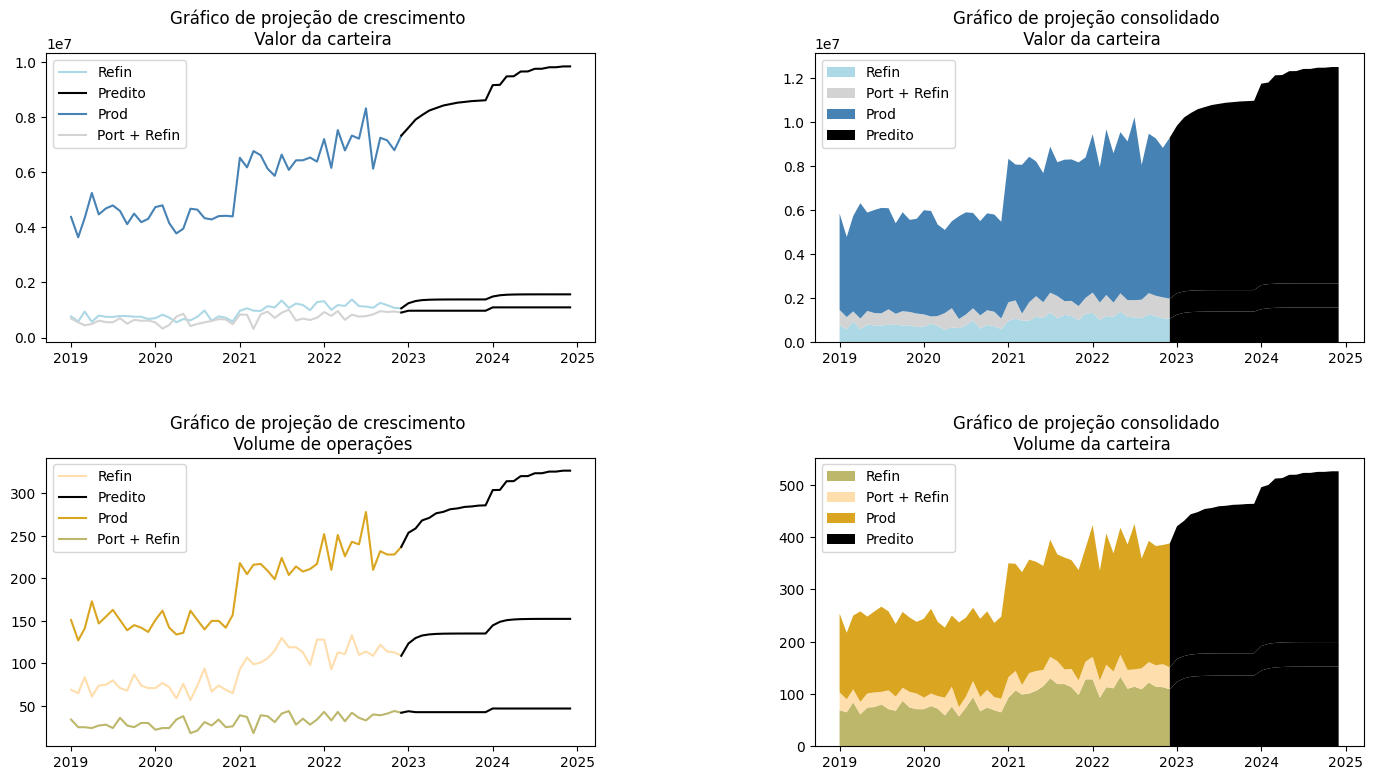

In [14]:
PlotPredito(df_final)

# Análise final

É possível observar que a projeção de crescimento em até 2 anos é a carteira aumentar o valor total em 3 milhões no valor_principal. Enquanto que no volume de operações deve subir de 300 mensais para pouco mais de 500. É possível observar que as série de valor e a série de volume de operações são altamente correlacionadas. 
As regressões se mostraram um bom instrumento para entender e modelar séries temporais, pelo menos para séries que possuem autocorrelação. A metodologia utilizando regressão deixou a desejar pra modelar a série estacionária e sem correlação, uma vez que o R2 e demais métricas ficaram bem abaixo.